In [2]:
import warnings
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.datasets import load_boston
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict, validation_curve, learning_curve
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.preprocessing import StandardScaler, scale
from sklearn.pipeline import make_pipeline
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score

In [3]:
%matplotlib inline
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

## Classification vs Regression

### Housing Data

In [4]:
house_sales = pd.read_csv(Path('..', '00_data', 'kc_house_data.csv'))
house_sales = house_sales.drop(
    ['id', 'zipcode', 'lat', 'long', 'date'], axis=1)
house_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 16 columns):
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(3), int64(13)
memory usage: 2.6 MB


### Select Features

In [5]:
X = house_sales.drop('price', axis=1)
y_reg = np.log(house_sales.price)

In [6]:
mi_reg = pd.Series(mutual_info_regression(X, y_reg),
                   index=X.columns).sort_values(ascending=False)
mi_reg

sqft_living      0.348340
grade            0.342235
sqft_living15    0.270283
sqft_above       0.259878
bathrooms        0.205627
bedrooms         0.086191
sqft_lot15       0.084773
yr_built         0.076743
floors           0.069342
sqft_basement    0.068322
sqft_lot         0.061574
view             0.056642
condition        0.011857
yr_renovated     0.009112
waterfront       0.008959
dtype: float64

In [7]:
X_reg = X.loc[:, mi_reg.iloc[:10].index]

### Explore Correlations

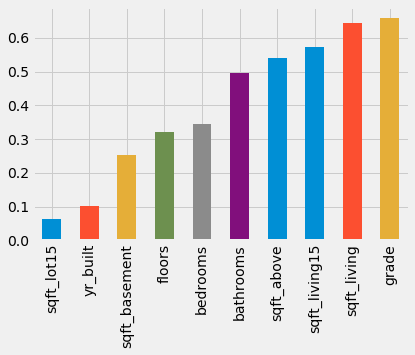

In [8]:
correl = X_reg.apply(lambda x: spearmanr(x, y_reg)).apply(
    pd.Series, index=['r', 'pval'])
correl.r.sort_values().plot.bar()

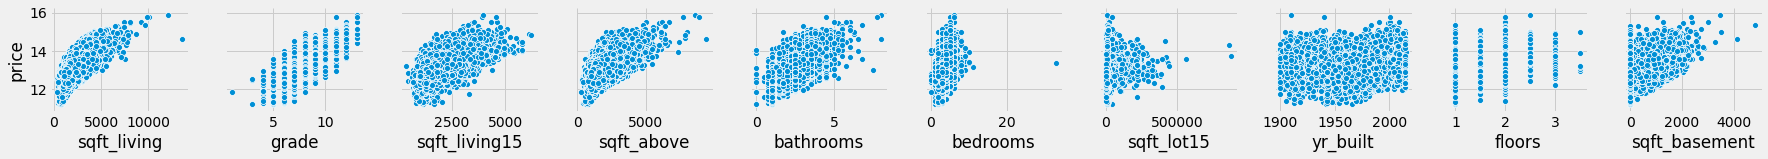

In [9]:
sns.pairplot(X_reg.assign(price=y_reg), y_vars=['price'], x_vars=X_reg.columns)

## KNN Regression

In [10]:
cv_mse = {}
n_neighbors = [1] + list(range(5, 251, 10))
for n in n_neighbors:
    pipe = make_pipeline(StandardScaler(),
                         KNeighborsRegressor(n_neighbors=n))
    cv_mse[n] = cross_val_score(pipe, X=X_reg, y=y_reg,
                                scoring='neg_mean_squared_error',
                                cv=5) * -1

In [11]:
cv_rmse = pd.DataFrame.from_dict(cv_mse, orient='index').pow(.5)
best_n, best_rmse = cv_rmse.mean(1).idxmin(), cv_rmse.mean(1).min()
cv_rmse = cv_rmse.stack().reset_index()
cv_rmse.columns =['n', 'fold', 'RMSE']

ax = sns.lineplot(x='n', y='RMSE', data=scores_df)

ax.set_title(f'Cross-Validation Results KNN | Best N: {best_n:d} | Best Score: {best_rmse:.2f}');

NameError: name 'scores_df' is not defined

In [ ]:
pipe = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=best_n))
pred = cross_val_predict(pipe, X_reg, y_reg, cv=5)

ax = sns.scatterplot(x=y_reg, y=pred)
y_range = list(range(int(y_reg.min() + 1), int(y_reg.max() + 1)))
pd.Series(y_range, index=y_range).plot(ax=ax, lw=2, c='darkred');

### Train & Validation Curves

In [ ]:
train_, valid_ = validation_curve(estimator=KNeighborsRegressor(),
                                  X=scale(X_reg), y=y_reg,
                                  param_name='n_neighbors',
                                  param_range=n_neighbors,
                                  scoring='neg_mean_squared_error')

In [ ]:
train_scores = pd.DataFrame(train_, index=n_neighbors).stack().mul(-1).pow(.5).to_frame('RMSE')
valid_scores = pd.DataFrame(valid_, index=n_neighbors).stack().mul(-1).pow(.5).to_frame('RMSE')

scores = pd.concat([train_scores.assign(Data='Training'),
                    valid_scores.assign(Data='Validation')])
scores.index.names = ['# Neighbors', 'fold']

ax = sns.lineplot(x='# Neighbors', y='RMSE',
                  hue='Data', data=scores.reset_index(), lw=2)
ax.set_title(f'Cross-Validation Results KNN | Best N: {best_n:d} | Best Score: {best_score:.2f}');
# ax.set_xlim(1, 250)
best_n = valid_scores.groupby(level=0).RMSE.mean().idxmin()
ax.axvline(best_n, ls='--', lw=1);

In [ ]:
train_sizes = list(range(100, 15001, 200))
knn = KNeighborsRegressor(n_neighbors=best_n)
_, train_, valid_ = learning_curve(estimator=knn,
                                   X=scale(X_reg), y=y_reg,
                                   train_sizes=train_sizes, cv=5,
                                   scoring='neg_mean_squared_error')

In [ ]:
train_scores = pd.DataFrame(train_, index=train_sizes).stack().mul(-1).pow(.5).to_frame('RMSE')
valid_scores = pd.DataFrame(valid_, index=train_sizes).stack().mul(-1).pow(.5).to_frame('RMSE')
scores = pd.concat([train_scores.assign(Data='Training'),
                    valid_scores.assign(Data='Validation')])
scores.index.names = ['Train Size', 'run']
ax = sns.lineplot(x='Train Size', y='RMSE', hue='Data',
                  data=scores.reset_index(), lw=2)
ax.set_title('Learning Curves')

### Classification

In [18]:
y_class = pd.qcut(y_reg, q=3, labels=[1, 2, 3])

In [19]:
mi_class = pd.Series(mutual_info_classif(X, y_class),
                     index=X.columns).sort_values(ascending=False)
mi_class

grade            0.228310
sqft_living      0.219525
sqft_living15    0.183674
sqft_above       0.167586
bathrooms        0.114724
sqft_lot15       0.091020
sqft_lot         0.057034
bedrooms         0.055573
floors           0.046059
view             0.041918
sqft_basement    0.040356
yr_built         0.030762
yr_renovated     0.010219
condition        0.003269
waterfront       0.001978
dtype: float64

In [20]:
X_class = X.loc[:, mi_class.iloc[:10].index]

In [66]:
cv_acc = {}
n_neighbors = [1] + list(range(5, 251, 10))
for n in n_neighbors:
    pipe = make_pipeline(StandardScaler(),
                         KNeighborsClassifier(n_neighbors=n))
    cv_acc[n] = cross_val_score(pipe, X=X_reg, y=y_class,
                                scoring='accuracy',
                                cv=5) * -1

ValueError: Unknown format code 'd' for object of type 'float'

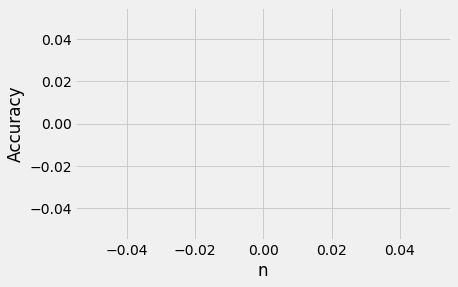

In [67]:
cv_accuracy = pd.DataFrame.from_dict(cv_acc, orient='index').pow(.5)
best_n, best_acc = cv_accuracy.mean(1).idxmin(), cv_accuracy.mean(1).min()
cv_accuracy = cv_accuracy.stack().reset_index()
cv_accuracy.columns =['n', 'fold', 'Accuracy']

ax = sns.lineplot(x='n', y='Accuracy', data=cv_accuracy)

ax.set_title(f'Cross-Validation Results KNN | Best N: {best_n:d} | Best Accuracy: {best_acc:.2f}');